In [19]:
import numpy as np
from scipy.stats import norm
import open3d as o3d
import igl
%run helpers_alg.ipynb


In [20]:


def readLbl(fileName):
    #takes in file name, returns the labels as an array
    file1 = open(fileName, 'r')
    Lines = file1.readlines()

    count = 0

    lbls = np.empty([600])
    # Strips the newline character
    for line in Lines:
        count += 1
        text = line.strip()[1:].split('.')
        text[1] = text[1].split(' ')[1]
        lbls[int(text[0])] = int(text[1])
        #print("Line{}: {}".format(count, )))
    return lbls


def lbl_2_lblMat(lbls):
    #takes in the labels as an array, returns an adjacency matrix between objects of same label
    labelMat = igl.all_pairs_distances(lbls, lbls, False)
    labelMat = np.where(labelMat > 0.5, 1, 0)
    return labelMat


def compareGroups(grpa, grpb, lbl, disSMat):
    #takes in two group indices, labels and dissimiliarity matrix, returns how similar they are as two groups
    grpA_idx = np.reshape(np.where(lbl == grpa), (20,))
    grpB_idx = np.reshape(np.where(lbl == grpb), (20,))
    A = disSMat[grpA_idx, :]
    B = A[:, grpB_idx]

    result = np.mean(B)

    if (grpa - grpb < 0.1):
        result = result * 20 / 19

    return result

# Test: DownSample Mesh

In [33]:
def obj_2_mesh(fileName):
    mesh = o3d.io.read_triangle_mesh(mesh_dir + fileName)
    # try different ways of downsampling method

    # combine closet vertices to form 250 faces -- not effective
    #simp_mesh = o3d.geometry.TriangleMesh.simplify_quadric_decimation(mesh, 250)
    # simp_mesh.compute_vertex_normals()

    lap_mesh = mesh.filter_smooth_laplacian(number_of_iterations=5)
    # simp_mesh.compute_vertex_normals()

    tau_mesh= lap_mesh.filter_smooth_taubin(number_of_iterations=50)

    final_mesh = tau_mesh
    v = np.asarray(final_mesh.vertices)
    f = np.asarray(final_mesh.triangles)

    print(v[0])
    print(f[0])
    return v, f

In [34]:

def obj_2_adj(v, f):
    #takes in file name, reads the .obj file and returns adjacency matrix scaled with edge values
    distances = igl.all_pairs_distances(v, v, False)
    adJ = igl.adjacency_matrix(f).toarray() * distances
    return adJ


def adj_2_features(adj):
    #some arbitrary ad-hoc function for extracting features, for testing only

    #print([np.mean(adj),np.max(adj),np.std(adj)])
    #hist = np.histogram(adj,bins = np.arange(0,0.5,0.02),density=True)
    #generic_feat = np.array([np.mean(adj),np.max(adj),np.std(adj)])
    hist = np.histogram(adj, bins=20, density=True)[0]
    #print(hist[0])

    return hist

In [35]:
mesh_dir = 'SHREC11/'
#ts = np.array([0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4])
ts = np.random.random(10) * 0.1

In [36]:
adjMats = []

for i in range(600):
    fName = 'T' + str(i) + '.obj'
    v, f = obj_2_mesh(fName)
    adj = obj_2_adj(v, f)
    adjMats.append(adj)

[-0.29511647 -0.03361045 -0.1252253 ]
[0 1 2]
[-0.59109717  0.06886993 -0.02392437]
[0 1 2]
[-0.23140174 -0.18291115 -0.02773719]
[0 1 2]
[-0.09745042 -0.09137788  0.08867556]
[0 1 2]
[-0.3169014  -0.08079967 -0.26212889]
[0 1 2]
[-0.06138802  0.0465496  -0.26586029]
[0 1 2]
[-0.43521734 -0.14175624  0.04030635]
[0 1 2]
[-0.30592071 -0.10638465  0.07856442]
[0 1 2]
[-0.22934226 -0.10296737 -0.0247622 ]
[0 1 2]
[ 0.27790981  0.4451274  -0.10278759]
[0 1 2]
[ 0.13381678 -0.11953153 -0.13825426]
[0 1 2]
[0.11134768 0.09850195 0.04759436]
[0 1 2]
[ 0.49913337  0.03454196 -0.05155888]
[0 1 2]
[-0.32450531  0.13960108  0.04611299]
[0 1 2]
[ 0.12846408 -0.25465329  0.24721014]
[0 1 2]
[0.10802405 0.02264207 0.47677201]
[0 1 2]
[-0.63919973  0.15706318  0.06355651]
[0 1 2]
[-0.49931357  0.32141861  0.48044789]
[0 1 2]
[-0.10343425 -0.05063895  0.22363729]
[0 1 2]
[ 0.49304732 -0.16273126  0.04135002]
[0 1 2]
[0.08258527 0.06290371 0.00657891]
[0 1 2]
[-0.19606122  0.03996343  0.00446888]
[0 1 

In [37]:
lapMats = adj_mat_to_lap_mat(adjMats)

In [38]:
evals,Us = lap_mat_to_eigen(lapMats)
hkss = batch_heat_kernel_signature(ts, evals, Us)

In [39]:
disSimMat = igl.all_pairs_distances(hkss,hkss,True)

In [40]:
disSimMat = disSimMat / np.max(disSimMat)

In [41]:
label = readLbl(mesh_dir+'labels.txt')
compResult = compareGroups(0,1,label,disSimMat)
np.mean(compResult)

0.052525080190004896

In [42]:
disSimMat2 = disSimMat + np.diag(np.ones(600))
print(divmod(np.argmin(disSimMat2),600))
print(np.min(disSimMat2))
print(label[59])
print(label[191])

(62, 417)
2.3654639098825276e-10
13.0
19.0


In [43]:
mat = np.empty([30,30])
compSelf = []
compOthers = []
for i in range(30):
    for j in range(0,i+1):
        compResult = compareGroups(i,j,label,disSimMat)
        mat[i,j] = compResult
        mat[j,i] = compResult
        if (i == j):
            compSelf.append(compResult)
        else:
            compOthers.append(compResult)

In [44]:
print(np.min(compSelf))
print(compOthers.index(np.min(compOthers)))

0.0009023553891643572
247


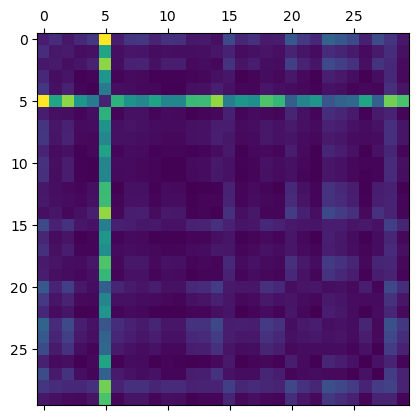

In [45]:
plt.matshow(mat)
self_mean = np.mean(compSelf)
self_std = np.std(compSelf)
others_mean = np.mean(compOthers)
others_std = np.std(compOthers)

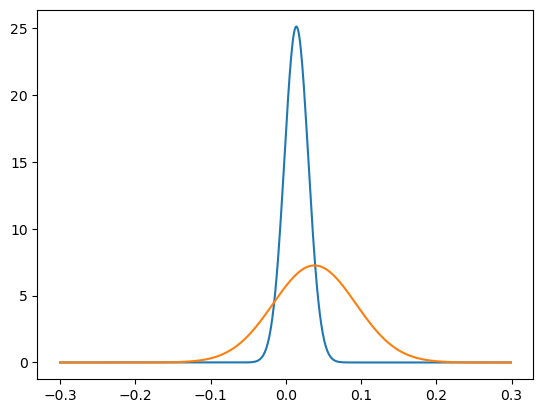

In [46]:
# Plot between -10 and 10 with .001 steps.
x_axis = np.arange(-0.3, 0.3, 0.001)

#plt.hist(compSelf)


plt.plot(x_axis, norm.pdf(x_axis, self_mean, self_std))
plt.plot(x_axis, norm.pdf(x_axis, others_mean, others_std))
plt.show()